In [1]:
import os
import pandas as pd
from natsort import natsorted
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread
from umap import UMAP
import hdbscan
from joblib import Memory
from matplotlib.lines import Line2D

In [2]:
core = '1'

save_dir = (
    '/Users/greg/Dropbox (HMS)/Baker_QC_2021/script_output/' +
    'dropout'
    )
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

markers = pd.read_csv(
    '/Volumes/My Book/cylinter_input/emit22_full/markers.csv'
    )

aoi = [
    i for i in list(markers['marker_name']) if not
    any(x in i for x in ['DNA', 'IgG', 'CD56', 'CD13', 'pAUR',
        'CCNE', 'CDKN2A', 'PCNA_1', 'CDKN1B_2'])
        ]

# read unfiltered EMIT TMA22 single-cell data
data = pd.read_parquet(
    '/Volumes/My Book/cylinter_input/emit22_full/output/checkpoints/areaFilter.parquet'
    )
core_data = data[data['Sample'] == core]

# isolate 'Sample' and Hoechst channel columns
dna_data = core_data[['Sample'] + [i for i in core_data.columns if 'DNA' in i]]

# isolate columns for antibodies of interest
cldata = core_data[
    [i for i in core_data.columns if i.split('_cellMask')[0] in aoi]
    ]
cldata = np.log10(cldata)

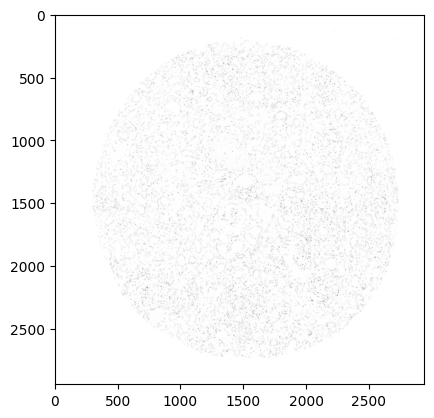

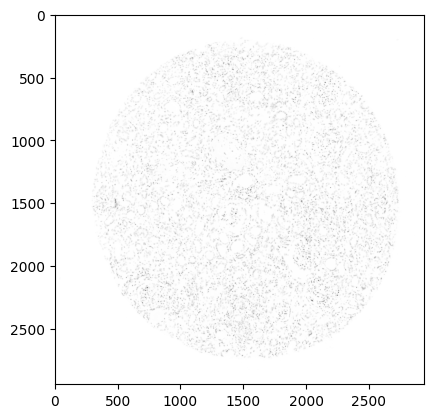

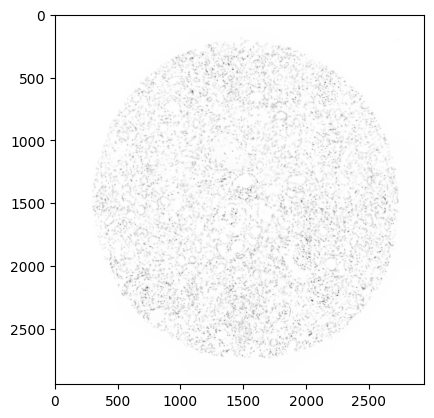

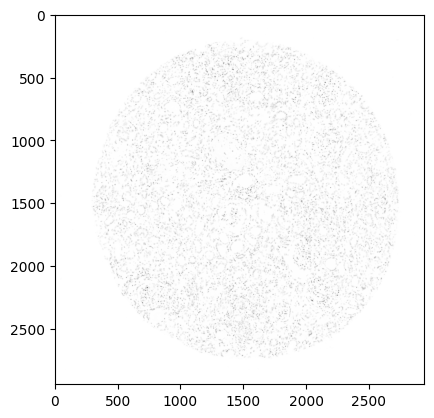

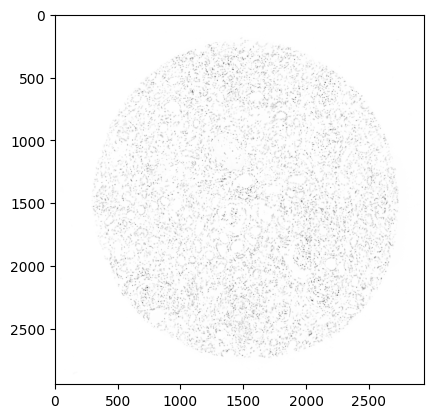

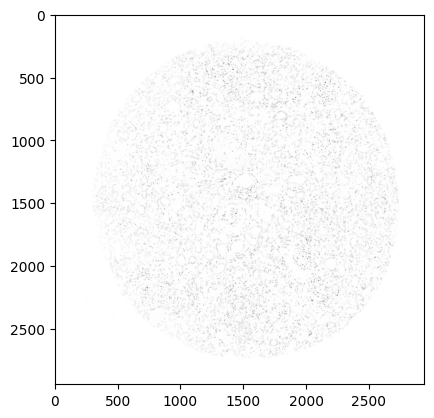

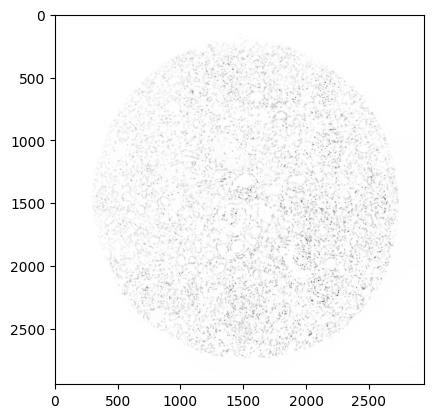

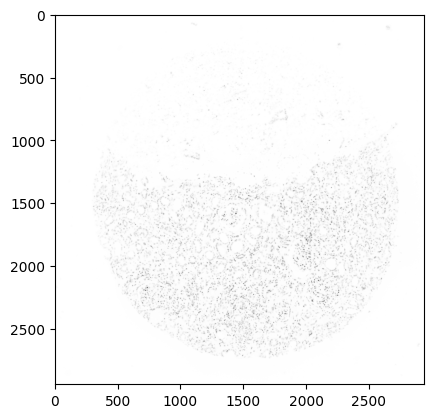

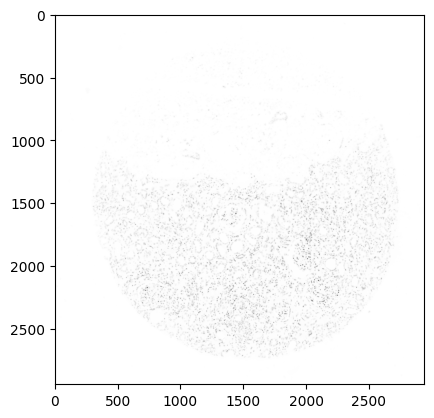

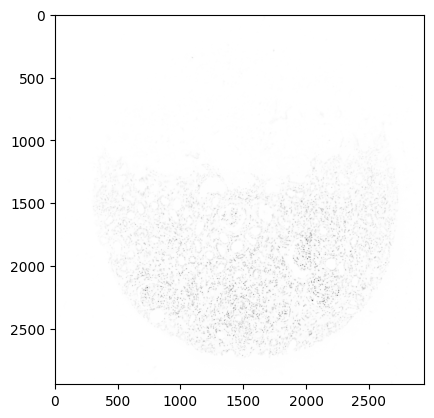

In [3]:
# save dna cycle images
for e, dna in enumerate([0, 4, 8, 12, 16, 20, 24, 28, 32, 36]):

    # read dna image for current cycle
    img = imread(
        f'/Volumes/My Book/cylinter_input/emit22_full/tif/{core}.ome.tif',
        key=dna
        )

    # binarize signals
    plt.imshow(img, cmap='Greys')
    plt.grid(False)
    plt.savefig(os.path.join(save_dir, f'dna_cycle{e+1}.png'), dpi=600)
    plt.show()
    plt.close('all')

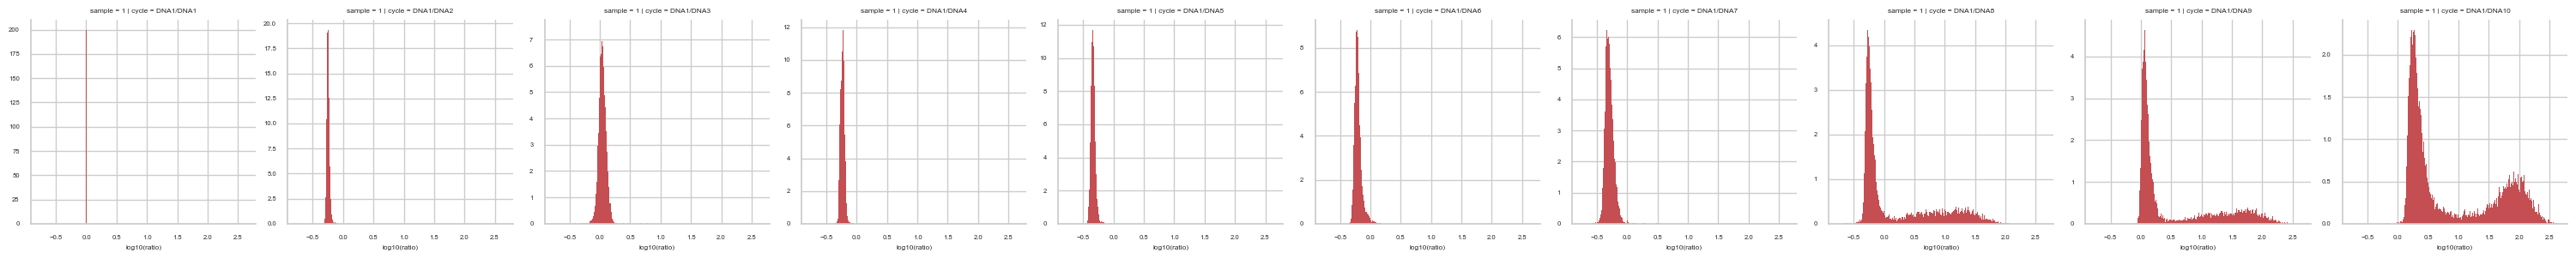

In [4]:
# plot log(ratio) histograms
dna_cycles = natsorted(
    [i for i in dna_data.columns if 'DNA' in i]
    )

ratios = pd.DataFrame(
    [np.log10(
        (dna_data['DNA1'] + 0.00001) /
        (dna_data[i] + 0.00001)) for i in dna_cycles]).T

list1 = [i for i in ratios.columns if i.startswith('Unnamed')]
list2 = [
    f'DNA1/{i}' for i in
    [j.split(f'_cellMask')[0] for j in dna_cycles[1:]]
    ]

ratio_columns = dict(zip(list1, list2))
ratio_columns['DNA1'] = 'DNA1/DNA1'
ratios.rename(columns=ratio_columns, inplace=True)
ratios['sample'] = dna_data['Sample']

ratios_melt = (
    ratios
    .reset_index()
    .melt(id_vars=['sample', 'index'], var_name='cycle',
          value_name='log10(ratio)')
    )

ratios_melt['sample'] = pd.Categorical(
    ratios_melt['sample'], ordered=True,
    categories=natsorted(
        ratios_melt['sample'].unique()))

ratios_melt['cycle'] = pd.Categorical(
    ratios_melt['cycle'], ordered=True,
    categories=natsorted(
        ratios_melt['cycle'].unique()))

ratios_melt = (
    ratios_melt.sort_values(['sample', 'cycle', 'index'])
    )

sns.set(font_scale=0.5)
sns.set_style('whitegrid')

g = sns.FacetGrid(
    ratios_melt, row='sample',
    col='cycle', sharey=False
    )

g = g.map(
    plt.hist, 'log10(ratio)', color='r', histtype='stepfilled',
    ec='none', range=None, bins=200, density=True
    )

plt.savefig(os.path.join(save_dir, 'cycle_correlation_logRatios.pdf'))
plt.show()
plt.close('all')

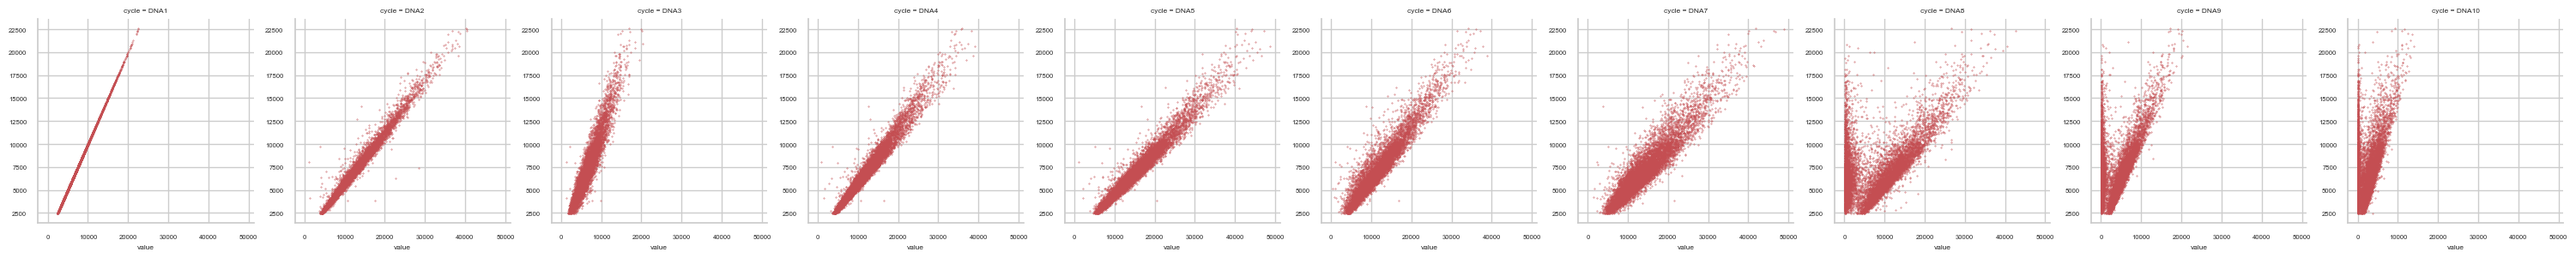

In [5]:
# plot cycle scatter plots before filtering cell dropout
facet_per_cycle_melt = (
    dna_data
    .sample(frac=1.0)
    .reset_index()
    .melt(id_vars=['Sample', 'index'], var_name='cycle',
          )
    )

facet_per_cycle_melt['Sample'] = pd.Categorical(
    facet_per_cycle_melt['Sample'], ordered=True,
    categories=natsorted(
        facet_per_cycle_melt['Sample'].unique()))

facet_per_cycle_melt['cycle'] = pd.Categorical(
    facet_per_cycle_melt['cycle'], ordered=True,
    categories=natsorted(
        facet_per_cycle_melt['cycle'].unique()))

facet_per_cycle_melt = (
    facet_per_cycle_melt.sort_values(['Sample', 'cycle', 'index'])
    )

# plot dna intensity correlation per cycle
# fig, ax = plt.subplots(figsize=(5, 5))
g = sns.FacetGrid(
    facet_per_cycle_melt, col='cycle', col_wrap=10,
    sharex=True, sharey=False
    )

g.map(
    lambda y, color: plt.scatter(
        y, facet_per_cycle_melt['value'].loc[
            facet_per_cycle_melt['cycle']
            == 'DNA1'],
        s=0.1, alpha=1.0, linewidth=None,
        marker='o', c='r'), 'value')

plt.savefig(os.path.join(save_dir, 'cycle_correlation_before.pdf'))
plt.show()
plt.close('all')

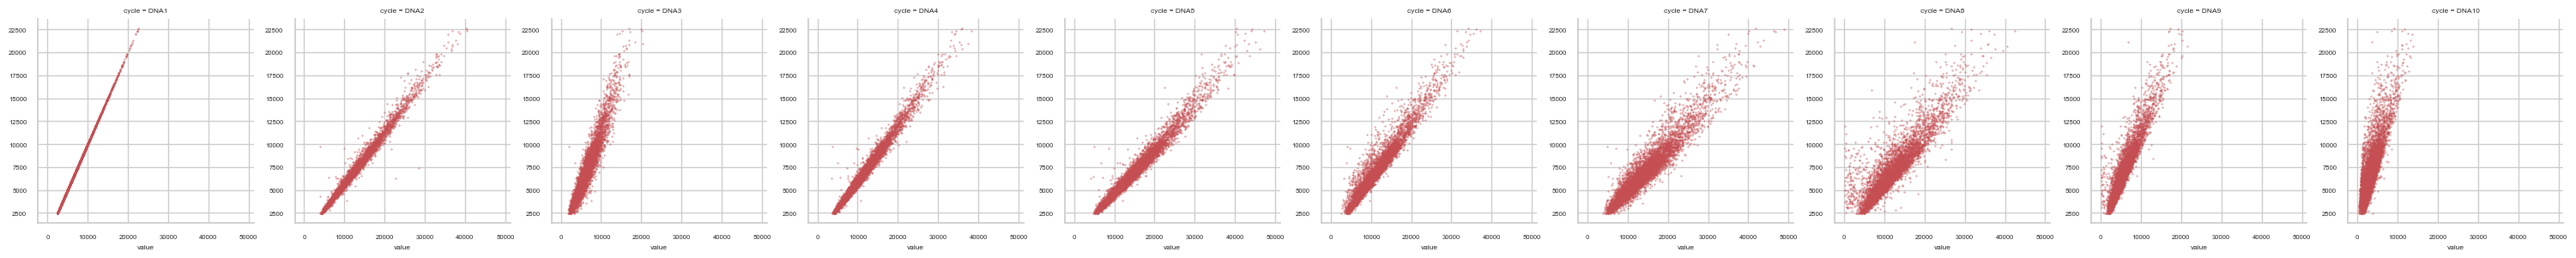

In [6]:
# plot cycle scatter plots after filtering cell dropout
dna_filtered = dna_data.copy()
dna_filtered['ratio'] = np.log10(
    dna_filtered['DNA1']/dna_filtered['DNA10']
    )
# select ratio cutoff value
dna_filtered = dna_filtered[dna_filtered['ratio'] < 0.9]  # 1.0
dna_filtered.drop(columns='ratio', inplace=True)

facet_per_cycle_melt = (
    dna_filtered
    .sample(frac=1.0)
    .reset_index()
    .melt(id_vars=['Sample', 'index'], var_name='cycle',
          )
    )

facet_per_cycle_melt['Sample'] = pd.Categorical(
    facet_per_cycle_melt['Sample'], ordered=True,
    categories=natsorted(
        facet_per_cycle_melt['Sample'].unique()))

facet_per_cycle_melt['cycle'] = pd.Categorical(
    facet_per_cycle_melt['cycle'], ordered=True,
    categories=natsorted(
        facet_per_cycle_melt['cycle'].unique()))

facet_per_cycle_melt = (
    facet_per_cycle_melt.sort_values(['Sample', 'cycle', 'index'])
    )

g = sns.FacetGrid(
    facet_per_cycle_melt, col='cycle', col_wrap=10,
    sharex=True, sharey=False
    )

g.map(
    lambda y, color: plt.scatter(
        y, facet_per_cycle_melt['value'].loc[
            facet_per_cycle_melt['cycle']
            == 'DNA1'],
        s=0.1, alpha=1.0, linewidth=None,
        marker='o', c='r'), 'value')

plt.savefig(os.path.join(save_dir, 'cycle_correlation_after.pdf'))
plt.show()
plt.close('all')

In [7]:
# embed and cluster single-cell data
embedding = UMAP(random_state=5).fit_transform(cldata)
cldata['emb1'] = embedding[:, 0]
cldata['emb2'] = embedding[:, 1]

clustering = hdbscan.HDBSCAN(min_cluster_size=50).fit(cldata[['emb1', 'emb2']])
cldata['cluster'] = clustering.labels_

colors = {-1: '#000000', 0: '#1f77b4', 1: '#ff7f0e', 2: '#2ca02c',
          3: '#d62728', 4: '#9467bd', 5: '#8c564b', 6: '#e377c2',
          7: '#7f7f7f', 8: '#bcbd22', 9: '#17becf'}
cldata['color_cluster'] = [colors[i] for i in cldata['cluster']]

stable_idx = dna_filtered.index

cldata['color_stability'] = [
    'gainsboro' if i in stable_idx else 'tab:blue'
    for i in cldata.index]

cldata['lw_stability'] = [0.0 if i in stable_idx else 0.1 for i in cldata.index]

/Users/greg/venvs/cylinter_test/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


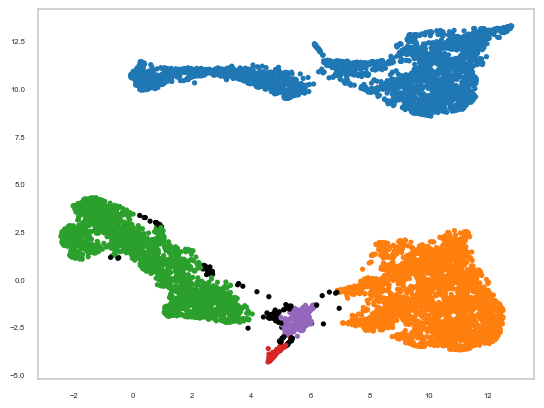

In [8]:
# color embedding by cluster
plt.scatter(cldata['emb1'], cldata['emb2'], c=cldata['color_cluster'], s=7.5)
plt.grid(False)

plt.savefig(os.path.join(save_dir, 'clustering_by_cluster.pdf'))
plt.show()
plt.close('all')

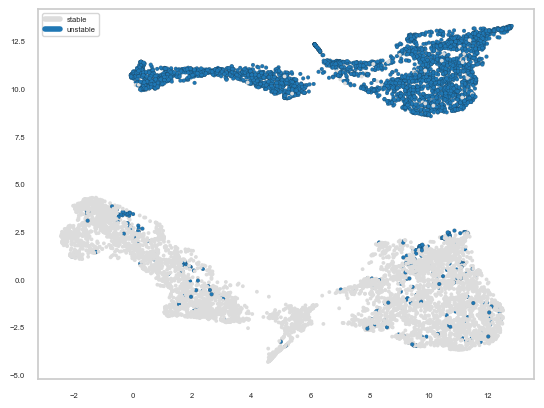

In [10]:
# color embedding by stability
plt.scatter(
    cldata['emb1'], cldata['emb2'], c=cldata['color_stability'],
    ec='k', lw=cldata['lw_stability'], s=7.5
)
plt.grid(False)

custom_lines = [Line2D([0], [0], color='gainsboro', lw=4),
                Line2D([0], [0], color='tab:blue', lw=4),
                ]
plt.legend(custom_lines, ['stable', 'unstable'])

plt.savefig(os.path.join(save_dir, 'clustering_by_stability.png'), dpi=1000)
plt.show()
plt.close('all')